# Sort spikes and make bout/motif rasters
For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [2]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import pickle

from matplotlib import pyplot as plt
from importlib import reload

from scipy.interpolate import interp1d

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [9]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex
from ceciestunepipe.util import plotutil as pu
from ceciestunepipe.util.spike import kilosort as ks
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2022-02-01 14:34:46,078 root         INFO     all modules loaded


### Session parameters and raw files

In [3]:
reload(et)

bird = 'z_y19o20_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [36]:
reload(et)
sess_par = {'bird': 'z_y19o20_21',
           'sess': '2021-12-23',
           'probe': 'probe_0',
           'sort': 'sort_pt'}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']


In [37]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx'

In [38]:
ksort_folder

'/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/sort_pt'

In [39]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2022-01-31 17:14:15,447 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21', 'raw': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23', 'sglx': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx', 'kwik': '/experiment/z_y19o20_21/sglx/kwik/2021-12-23', 'processed': '/mnt/sphere/speech_bci/processed_data/z_y19o20_21/2021-12-23/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/z_y19o20_21/sglx/msort/2021-12-23', 'ksort': '/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/sort_pt', 'sort': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/sort_pt'}, 'files': {'par': '/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/sort_pt/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/rig.json', 'kwd': '/experim

['0602_female_pin_g0',
 '1005_female_pin-undirected_g0',
 '1032_female_pin-undirected_g0',
 '1137_female_pin-directed_g0',
 '1437_female_pin-directed_g0',
 '1451_female_pin-directed_g0',
 '1512_female_pin-directed_g0',
 '2203_night_replay_female_pin_g0']

In [40]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[-2] 
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [11]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/1512_female_pin-directed_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/1512_female_pin-directed_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'kwik': '/experiment/z_y19o20_21/sglx/kwik/2021-12-23/1512_female_pin-directed_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'tmp': '/experiment/tmp/tmp/1512_female_pin-directed_g0',
  'msort': '/experiment/tmp/z_y19o20_21/sglx/msort/2021-12-23/1512_female_pin-directed_g0',
  'ksort': '/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/1512_female_pin-directed_g0/sort_pt',
  'sort': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/sort_pt'},
 'files': {'par': '/experiment/tmp/z

In [12]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/1512_female_pin-directed_g0_imec0'}

In [13]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/1512_female_pin-directed_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/1512_female_pin-directed_g0_imec0/1512_female_pin-directed_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/1512_female_pin-directed_g0_imec0/1512_female_pin-directed_g0_t0.imec0.ap.meta']}

In [14]:
files_pd = pd.DataFrame(sgl_files)
files_pd

,nidq,lf_0,ap_0
0,/mnt/sphere/speech_bci/raw_data/z_y19o20_21/20...,/mnt/sphere/speech_bci/raw_data/z_y19o20_21/20...,/mnt/sphere/speech_bci/raw_data/z_y19o20_21/20...


### load epoch files

In [15]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]

mic_file_name

'/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/wav_mic.wav'

# Load sync channels

In [16]:
def load_syn_dict(exp_struct: dict, stream:str, arrays_to_load=['evt_arr', 't_0']) -> dict:
    
    syn_dict_path = os.path.join(exp_struct['folders']['derived'],  
                                 '{}_sync_dict.pkl'.format(stream))
    logger.info('loading syn_dict from ' + syn_dict_path)
    with open(syn_dict_path, 'rb') as f:
        syn_dict = pickle.load(f)
     
    for arr in arrays_to_load:
        arr_path = syn_dict['{}_path'.format(arr)]
        syn_dict[arr] = np.load(arr_path, mmap_mode='r')
    return syn_dict

def get_syn_pattern(run_recs_dict, exp_struct, stream:str, force=False):
    logger.info('getting syn patterns for {}'.format(stream))
    syn_dict_path = os.path.join(exp_struct['folders']['derived'], '{}_sync_dict.pkl'.format(stream))
    
    # if Force=true of file not found, compute it from the recording_dict
    if not(os.path.exists(syn_dict_path) and (force is False)):
        logger.info('File {} not found or forced computation, getting the events'.format(syn_dict_path))
        syn_tuple = run_recs_dict[stream].get_effective_sf()
        syn_arr = np.vstack(list(syn_tuple[2][:]))
        
        t_0_path = os.path.join(exp_struct['folders']['derived'],  '{}_t0.npy'.format(stream))
        syn_npy_path = os.path.join(exp_struct['folders']['derived'],  '{}_sync_evt.npy'.format(stream))
                                 
        logger.info('saving events array to ' + syn_npy_path)
        np.save(syn_npy_path, syn_arr)
        
        logger.info('saving t_0 array to ' + t_0_path)                                 
        np.save(t_0_path, syn_tuple[1])
        
        syn_dict = {'path': syn_dict_path,
                    's_f': syn_tuple[0],
                   't_0_path': t_0_path,
                    'evt_arr_path': syn_npy_path
                   }
        
        # save without the array, and open the array as a memmap
        logger.info('saving sync dict to ' + syn_dict_path)
        with open(syn_dict_path, 'wb') as pf:
            pickle.dump(syn_dict, pf)
    
#     else:
#         syn_dict = load_syn_dict(exp_struct, stream, arrays_to_load=[])
#         syn_dict['path'] = syn_dict_path
#         # save without the array, and open the array as a memmap
#         logger.info('saving sync dict to ' + syn_dict_path)
#         with open(syn_dict_path, 'wb') as pf:
#             pickle.dump(syn_dict, pf)
            
    ## in any case, load the saved dict so everything comes from the memmaped arrays
    syn_dict = load_syn_dict(exp_struct, stream) 
        
    return syn_dict

In [17]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

2022-01-31 17:10:02,078 root         INFO     getting syn patterns for nidq
2022-01-31 17:10:02,122 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/nidq_sync_dict.pkl
2022-01-31 17:10:44,530 root         INFO     getting syn patterns for lf_0
2022-01-31 17:10:44,532 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/lf_0_sync_dict.pkl
2022-01-31 17:10:47,158 root         INFO     getting syn patterns for ap_0
2022-01-31 17:10:47,224 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/ap_0_sync_dict.pkl
2022-01-31 17:10:47,244 root         INFO     getting syn patterns for wav
2022-01-31 17:10:47,245 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/

In [18]:
all_syn_dict['wav']

{'s_f': 40000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/wav_sync_evt.npy',
 'path': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/wav_sync_dict.pkl',
 'evt_arr': memmap([[     5795,     25795,     45794, ..., 527637169, 527657169,
          527677169],
         [       -1,         1,        -1, ...,        -1,         1,
                 -1]]),
 't_0': memmap([0.0000000e+00, 2.5000000e-05, 5.0000000e-05, ..., 1.3192192e+04,
         1.3192192e+04, 1.3192192e+04]),
 't_p_path': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/wav-tp.npy'}

# Load the numpy array with the motifs

In [20]:
mot_arr_name = 'mot_wav_mic.npy'
mot_arr_path = os.path.join(exp_struct['folders']['derived'], mot_arr_name)
hand_mot_arr_s = np.load(mot_arr_path)

hand_mot_arr_s.shape

(38, 2)

In [21]:
hand_mot_arr_s

array([[  389.286,   390.047],
       [  390.252,   391.013],
       [  391.133,   391.894],
       [  392.027,   392.788],
       [  394.72 ,   395.481],
       [  529.422,   530.183],
       [  530.397,   531.158],
       [ 2076.648,  2077.409],
       [ 2077.501,  2078.262],
       [ 2078.484,  2079.245],
       [ 2079.386,  2080.147],
       [ 2080.95 ,  2081.711],
       [ 2146.95 ,  2147.711],
       [ 2147.796,  2148.557],
       [ 2148.789,  2149.55 ],
       [ 2149.678,  2150.439],
       [ 3040.1  ,  3040.861],
       [ 3040.967,  3041.728],
       [ 3041.855,  3042.616],
       [ 3424.03 ,  3424.791],
       [ 3424.885,  3425.646],
       [ 6225.63 ,  6226.391],
       [ 6226.475,  6227.236],
       [ 6227.471,  6228.232],
       [ 8328.269,  8329.03 ],
       [ 8329.072,  8329.833],
       [ 8329.923,  8330.684],
       [ 9359.178,  9359.939],
       [ 9360.155,  9360.916],
       [ 9648.373,  9649.134],
       [ 9649.207,  9649.968],
       [ 9650.392,  9651.153],
       [

In [24]:
def bout_dict_from_array(bout_arr: np.array, all_syn_dict: dict) -> dict:
    
    file = os.path.join(exp_struct['folders']['derived'], 'mot_dict_ap0.pkl')
    if os.path.exists(file):
        logger.info('mot_dict_ap0.pkl already exists. Loading mot_dict_ap0.pkl')
        with open(file, 'rb') as f:
            return pickle.load(f)
    
    s_f_wav = all_syn_dict['wav']['s_f']
    
    start_ms = (bout_arr[:, 0]*1000).astype(np.int64)
    len_ms = (np.diff(bout_arr)*1000).astype(np.int64).flatten()
    
    
    bout_dict = {
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': all_syn_dict['nidq']['s_f'],
            's_f_ap_0': all_syn_dict['ap_0']['s_f'],
           'start_ms': start_ms,
            'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int64),
           'start_sample_nidq': np.array([np.where(all_syn_dict['nidq']['t_0'] > start)[0][0] for start in start_ms*0.001]),
            'start_sample_wav': np.array([np.where(all_syn_dict['wav']['t_0'] > start)[0][0] for start in start_ms*0.001])
           }
    
    start_ms_ap_0 = all_syn_dict['wav']['t_p'][bout_dict['start_sample_wav']]*1000
    
    bout_dict['start_ms_ap_0'] = start_ms_ap_0
    bout_dict['start_sample_ap_0'] = np.array([np.where(all_syn_dict['ap_0']['t_0'] > start)[0][0] for start in start_ms_ap_0*0.001])
    bout_dict['start_sample_ap_0'] = (bout_dict['start_sample_ap_0']).astype(np.int64)
    return bout_dict

bout_dict = bout_dict_from_array(hand_mot_arr_s, all_syn_dict)
bout_dict

2022-01-31 17:11:54,444 root         INFO     mot_dict_ap0.pkl already exists. Loading mot_dict_ap0.pkl


{'s_f': 40000,
 's_f_nidq': 39999.34609407573,
 's_f_ap_0': 30000.035174165183,
 'start_ms': array([  389286,   390252,   391133,   392027,   394720,   529422,
          530397,  2076648,  2077501,  2078484,  2079386,  2080949,
         2146950,  2147796,  2148789,  2149678,  3040100,  3040967,
         3041855,  3424030,  3424885,  6225630,  6226475,  6227471,
         8328269,  8329072,  8329923,  9359178,  9360155,  9648373,
         9649207,  9650392,  9866830, 10484646, 10485484, 10487776,
        11213673, 11214573]),
 'len_ms': array([761, 761, 761, 761, 760, 760, 760, 760, 760, 760, 760, 761, 761,
        761, 760, 760, 760, 760, 760, 760, 760, 761, 760, 760, 761, 761,
        760, 761, 761, 761, 761, 761, 761, 761, 761, 761, 761, 761]),
 'start_sample_naive': array([ 15571440,  15610080,  15645320,  15681080,  15788800,  21176880,
         21215880,  83065920,  83100040,  83139360,  83175440,  83237960,
         85878000,  85911840,  85951560,  85987120, 121604000, 121638680,


### Save the mot_dict data

In [25]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/1512_female_pin-directed_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/1512_female_pin-directed_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'kwik': '/experiment/z_y19o20_21/sglx/kwik/2021-12-23/1512_female_pin-directed_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'tmp': '/experiment/tmp/tmp/1512_female_pin-directed_g0',
  'msort': '/experiment/tmp/z_y19o20_21/sglx/msort/2021-12-23/1512_female_pin-directed_g0',
  'ksort': '/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/1512_female_pin-directed_g0/sort_pt',
  'sort': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/sort_pt'},
 'files': {'par': '/experiment/tmp/z

In [ ]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_ap0.pkl')
with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

# LOAD the sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

In [26]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [27]:
ap_extractor = run_recordings['ap_0']

###### view it raw

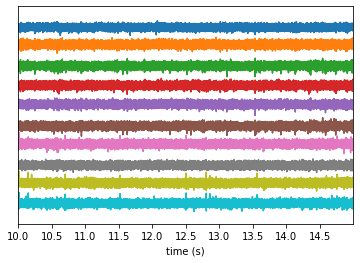

In [28]:
sw.plot_timeseries(ap_extractor, channel_ids=range(30, 40), trange=[10,15])

###### filtered

In [29]:
# ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
# sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

In [30]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

## Load the sort

In [31]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/1512_female_pin-directed_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/1512_female_pin-directed_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'kwik': '/experiment/z_y19o20_21/sglx/kwik/2021-12-23/1512_female_pin-directed_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0',
  'tmp': '/experiment/tmp/tmp/1512_female_pin-directed_g0',
  'msort': '/experiment/tmp/z_y19o20_21/sglx/msort/2021-12-23/1512_female_pin-directed_g0',
  'ksort': '/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/1512_female_pin-directed_g0/sort_pt',
  'sort': '/mnt/sphere/speech_bci/derived_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0/sort_pt'},
 'files': {'par': '/experiment/tmp/z

In [32]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle.dump.pkl')
sort_pickle_path

'/experiment/tmp/z_y19o20_21/sglx/ksort/2021-12-23/1512_female_pin-directed_g0/sort_pt/sort_ks3.pickle.dump.pkl'

In [33]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [49]:
### load the sort directly from kilosort npy files
ksort_folder = exp_struct['folders']['ksort']

ks.load_spikes?

Signature: ks.load_spikes(ks_folder: str, curated=False) -> tuple
Docstring: <no docstring>
File:      ~/repos/ceciestunepipe/ceciestunepipe/util/spike/kilosort.py
Type:      function


In [50]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(ksort_folder, 'tmp_ks3'), curated=True)
spk_df.head(3)

,times,clusters,cluster_id
0,207,56,56
1,226,233,233
2,238,60,60


# Plot raw traces and label HVC and RA channels

In [65]:
hvc_chans = list(range(260, 334)) #HVC
ra_chans = list(range(35, 130)) #RA
# neuropix_channels = list(range(0,384)) #Neuropixel

# neur_chans = neuropix_channels
neur_chans = hvc_chans + ra_chans

s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])
ap_sf = all_syn_dict['ap_0']['s_f']

mot_idx = 10
mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 4 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

/tmp/ipykernel_2017727/1284041362.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


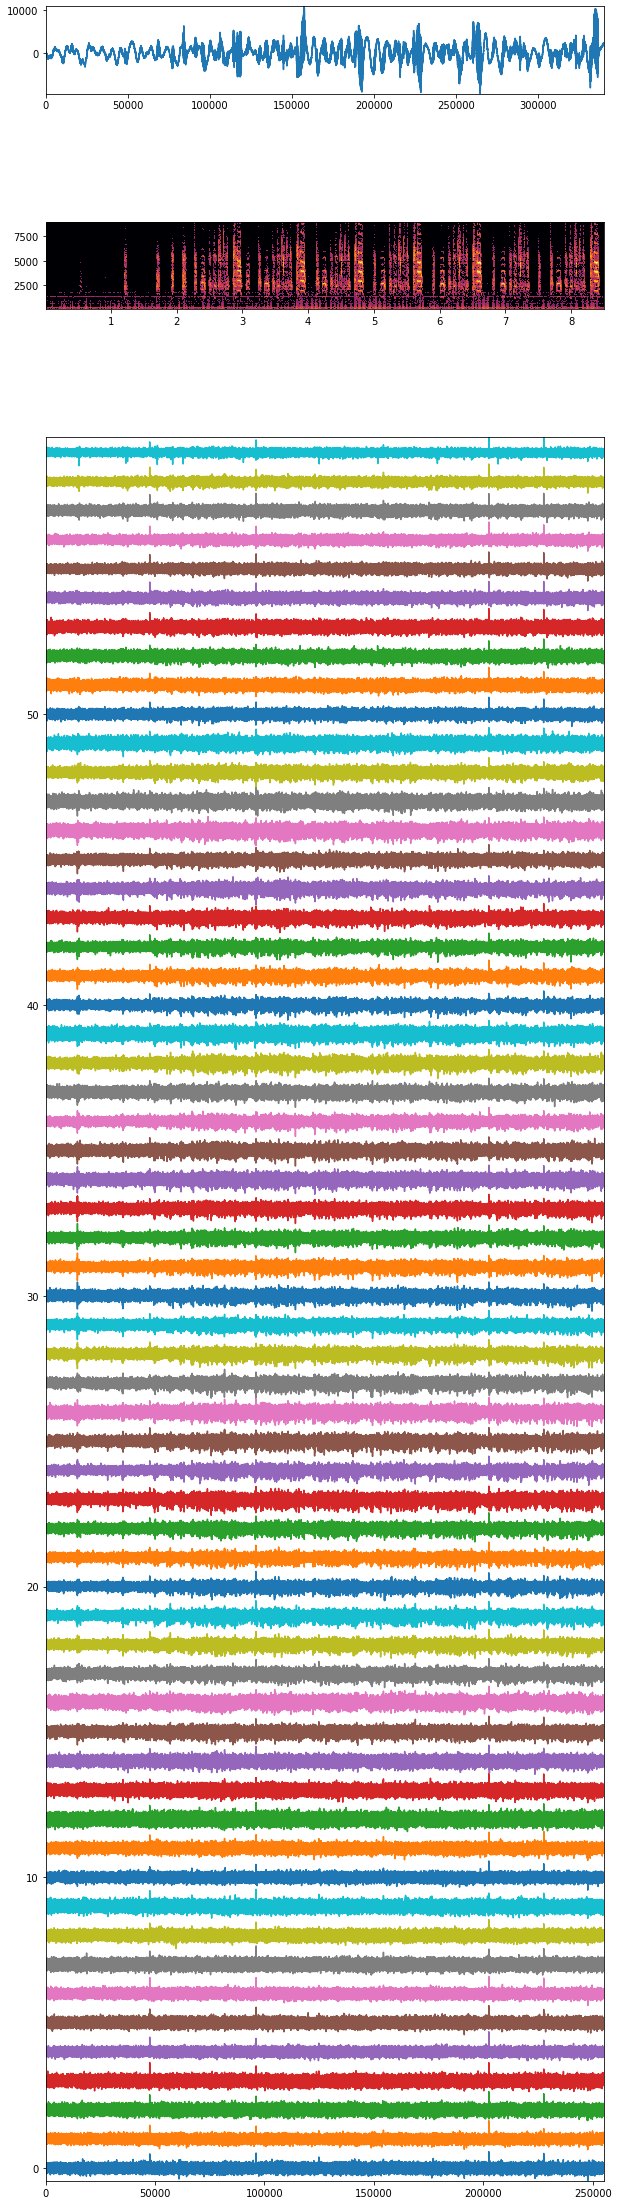

In [63]:
# HVC #
hvc_chans = list(range(270, 330)) #HVC
ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=hvc_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 45))
f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)
ax[0].plot(mic_arr.flatten())
ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
pu.plot_array(ap_arr_arr.T.astype(float), ax=ax[2])

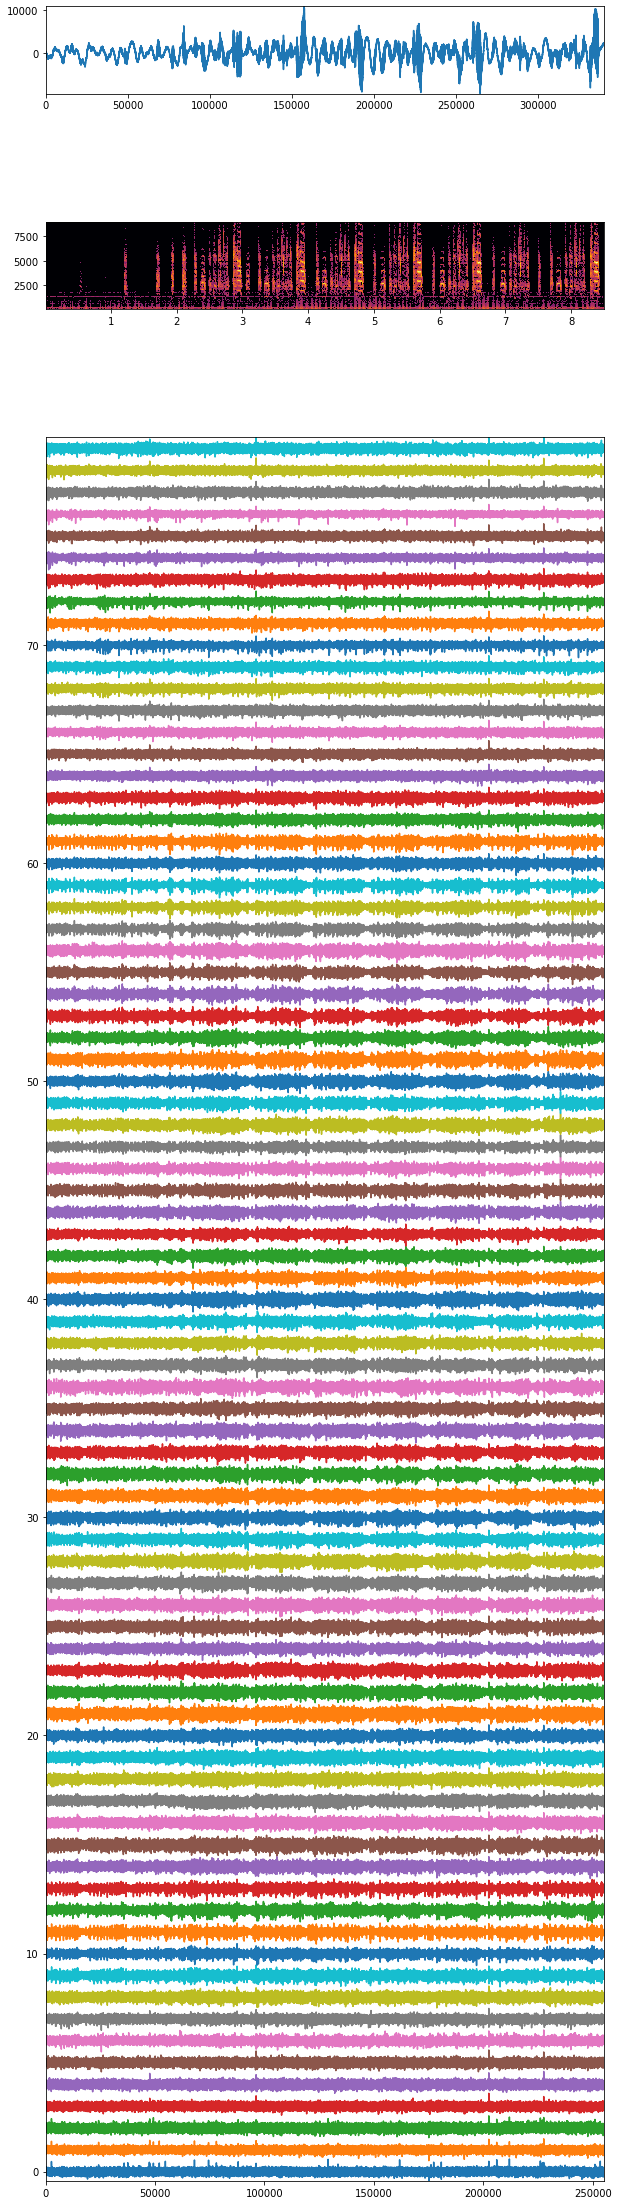

In [64]:
# RA #
ra_chans = list(range(38, 118)) #RA
ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=ra_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 45))
f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)
ax[0].plot(mic_arr.flatten())
ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
pu.plot_array(ap_arr_arr.T.astype(float), ax=ax[2])

In [66]:
## call the HVC/RA sites
hvc_chans = np.arange(270, 334)
clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
ra_chans = np.arange(38, 118)
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [67]:
clu_df.head(1)

,cluster_id,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,main_chan,MSLabel,has_template,template,max_chans,main_7,main_wav_7,nucleus
1,1,1289.4,100.0,mua,54.711014,0,0.0,5.825389,good,76851,0,0,good,True,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 4, 6, 2, 3, 7, 14, 15, 13, 5, 8, 9, 12,...","[0, 1, 2, 3, 4, 6, 7]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [68]:
clu_df_ra = clu_df[clu_df['nucleus']=='ra']
np.unique(clu_df_ra['cluster_id']).size

50

In [69]:
clu_df_ra = clu_df[clu_df['nucleus']=='hvc']
np.unique(clu_df_ra['cluster_id']).size

46

In [70]:
# count the mua ones
np.unique(clu_df[clu_df['KSLabel']=='mua']['cluster_id']).size

209

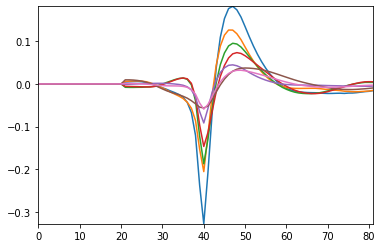

In [71]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

### plot a raster

### Visualize a bout together with the neural traces

#### check alignment of the syn signals

In [98]:
## have to do it, but it won't be like this
# n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
# ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

# n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
# nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

In [99]:
# mot_idx = 8
# sec_before = 0
# sec_after = 10

# for mot_idx in range(2):
#     start_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
#     end_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

#     start_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
#     end_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

#     fig, ax = plt.subplots(nrows=2)
#     ax[0].plot(ap_syn[start_ap: end_ap], '-*')
#     ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
#     ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [74]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = 0
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)
    

spk_arr = get_window_spikes(spk_df, clu_list, start_ap , end_ap)


#rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

/tmp/ipykernel_2017727/976175239.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [75]:
clu_list.size

26

/tmp/ipykernel_2017727/976175239.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


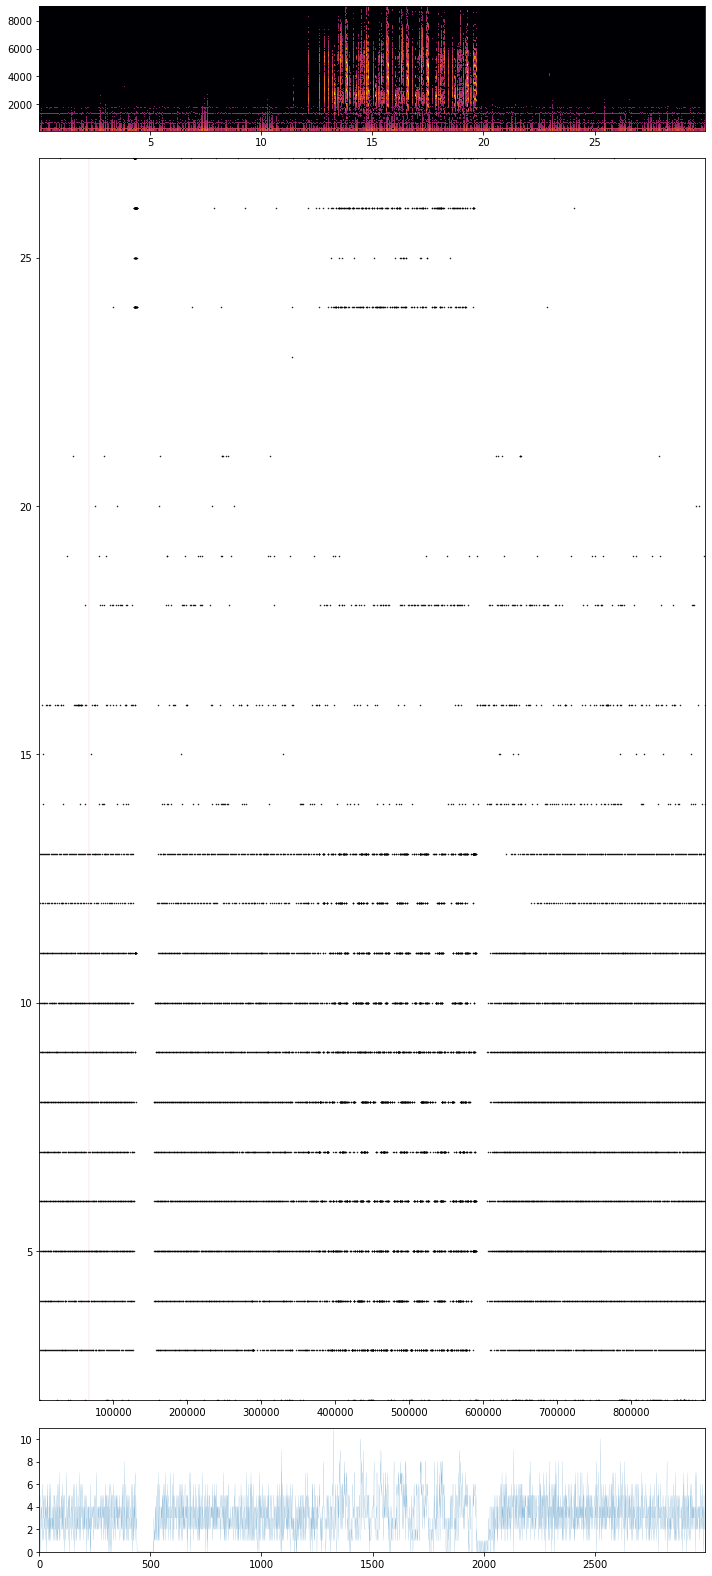

In [76]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax


#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 2
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [77]:
bin_size_sample

300

/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


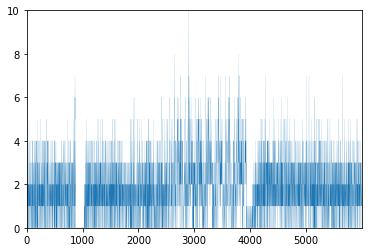

In [78]:
# plot a 'psth' of the summed activity of all units
bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'] )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

plt.plot(psth);

In [79]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### Now same one for MUA

/tmp/ipykernel_2017727/976175239.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


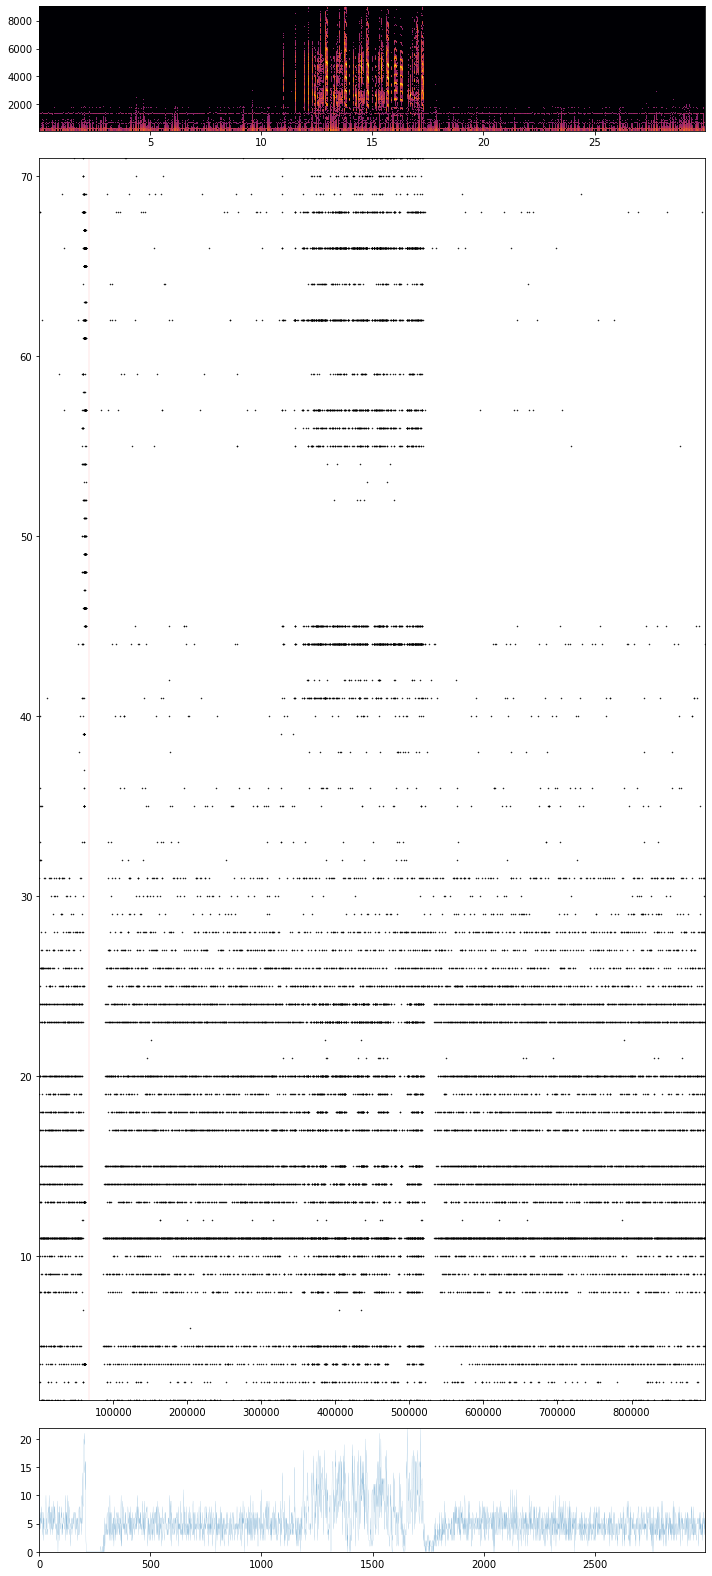

In [80]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 10
start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [81]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_mua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### Now the end of the bout

/tmp/ipykernel_2017727/976175239.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


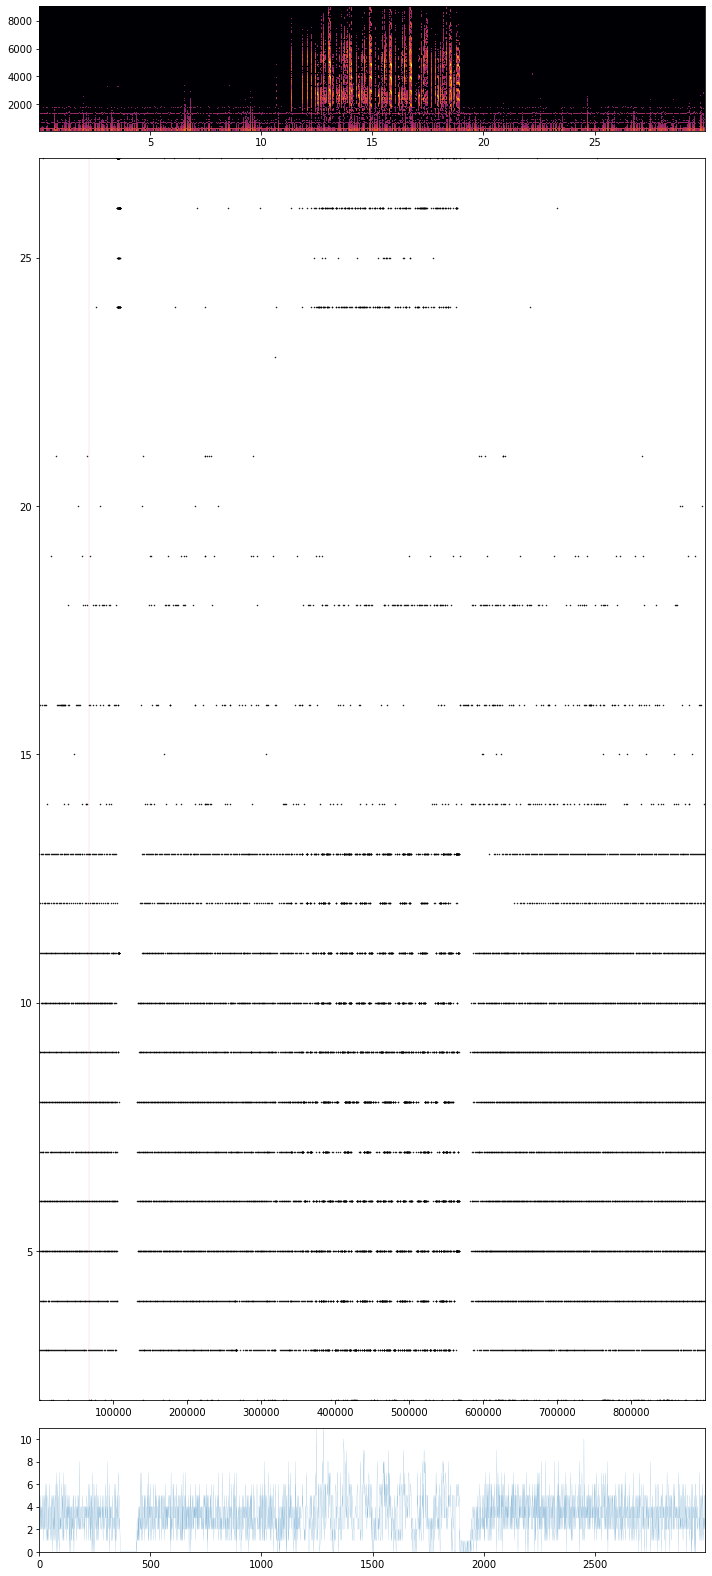

In [82]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)

##Pick a bout
bout_idx = 2

#shift everything to the end of the bout
len_bout_s = bout_dict['len_ms'][bout_idx]/1000
t_pre += len_bout_s
t_post += len_bout_s

start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

/tmp/ipykernel_2017727/976175239.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


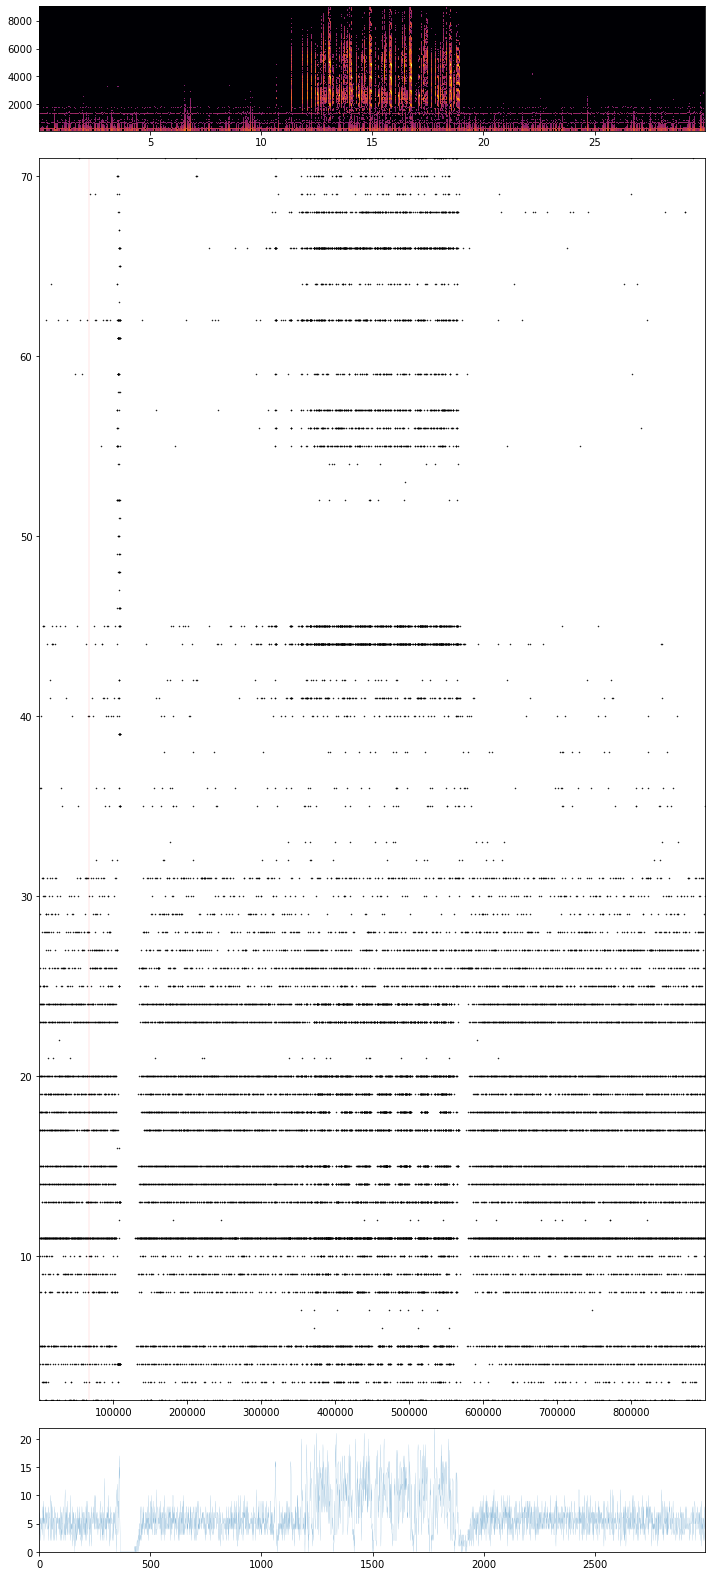

In [83]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='mua') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)

##Pick a bout
bout_idx = 2

#shift everything to the end of the bout
len_bout_s = bout_dict['len_ms'][bout_idx]/1000
t_pre += len_bout_s
t_post += len_bout_s

start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

## Now an entire bout

/tmp/ipykernel_2017727/976175239.py:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


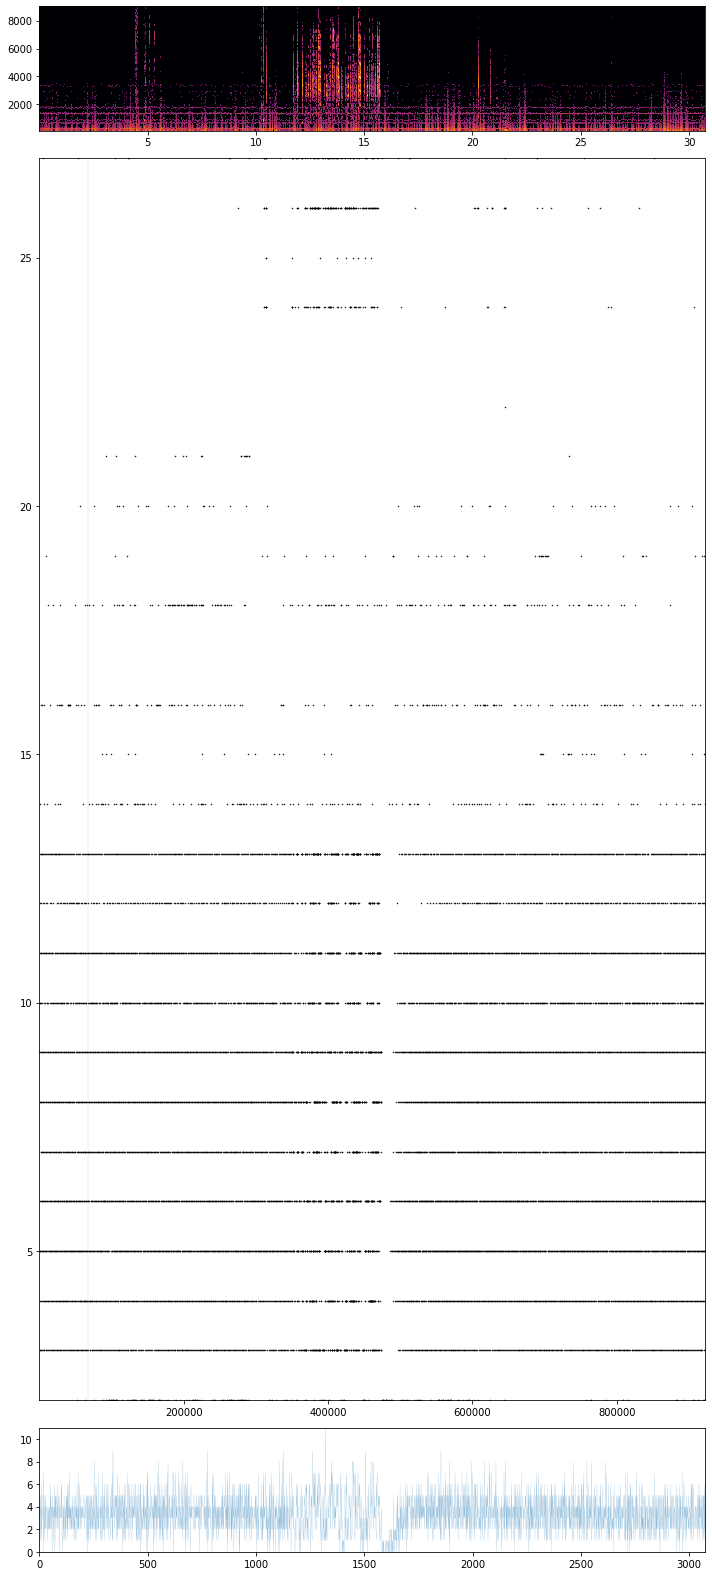

In [84]:
#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)

##Pick a bout
bout_idx = 15

#shift everything to the end of the bout
len_bout_s = bout_dict['len_ms'][bout_idx]/1000

t_pre += 0
t_post += len_bout_s

start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_pre)
end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f']* t_post)


# get the streams/spike array
spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
mic_arr = mic_stream[start_wav: end_wav]


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [85]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1-complete-mua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster, motif and cluster metadata

In [86]:
import pickle

In [1]:
exp_struct['folders']['derived']

NameError: name 'exp_struct' is not defined

In [87]:
clu_df_path = os.path.join(exp_struct['folders']['derived'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['derived'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)


In [88]:
exp_struct['folders']['derived']

'/mnt/sphere/speech_bci/processed_data/z_y19o20_21/2021-12-23/sglx/1512_female_pin-directed_g0'